In [1]:
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [101]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
start_date = '2015-01-01'
end_date = '2015-12-31'
t_min, t_avg, t_max = calc_temps(start_date, end_date)[0]
t_min, t_avg, t_max


(56.0, 73.8603305785124, 86.0)

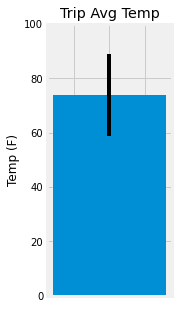

In [102]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.figure(figsize=(2,5))
plt.bar(x=0, height=t_avg, yerr=(t_max-t_min)/2)
plt.title('Trip Avg Temp'), plt.ylabel('Temp (F)'), plt.ylim(0,100), plt.tick_params(axis='x', labelbottom=False)
plt.show()



### Daily Rainfall Average

In [130]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
columns = ['Station', 'Name', 'Latitude', 'Longitude', 'Elevation', 'Sum_Prcp']

results = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).join(Measurement, Station.station == Measurement.station).group_by(Station.station).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).order_by(func.sum(Measurement.prcp).desc()).all()
pd.DataFrame(results, columns=columns)

,Station,Name,Latitude,Longitude,Elevation,Sum_Prcp
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,165.52
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,87.70
2,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,56.93
3,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,53.49
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,41.55
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,18.36
6,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9,6.09
7,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,3.62
8,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6,0.00


### Daily Temperature Normals

In [131]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [181]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
date_range = pd.date_range(start_date,end_date)

# Strip off the year and save a list of strings in the format %m-%d
formatted_list = [dt.datetime.strftime(date,'%m-%d') for date in date_range]

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals = [daily_normals(date)[0] for date in formatted_list]

normals

[(67.0, 75.54, 83.0),
 (68.0, 75.60377358490567, 84.0),
 (70.0, 76.61111111111111, 85.0),
 (69.0, 76.71153846153847, 84.0),
 (69.0, 76.14814814814815, 82.0),
 (67.0, 76.25, 83.0),
 (71.0, 77.15686274509804, 83.0)]

In [188]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame(normals, columns=['tmin','tavg', 'tmax'], index=date_range)
df.index.name = 'Date'
df

,tmin,tavg,tmax
Date,,,
2017-08-01,67.0,75.540000,83.0
2017-08-02,68.0,75.603774,84.0
2017-08-03,70.0,76.611111,85.0
2017-08-04,69.0,76.711538,84.0
2017-08-05,69.0,76.148148,82.0
2017-08-06,67.0,76.250000,83.0
2017-08-07,71.0,77.156863,83.0


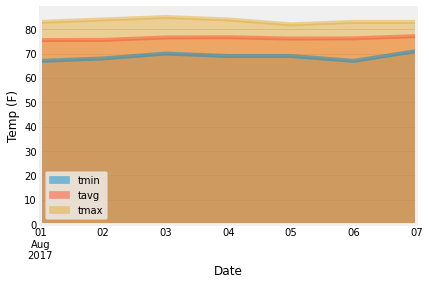

In [194]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot.area(stacked=False), plt.ylabel('Temp (F)')
plt.show()

## Close Session

In [195]:
session.close()